#1. Không xoay

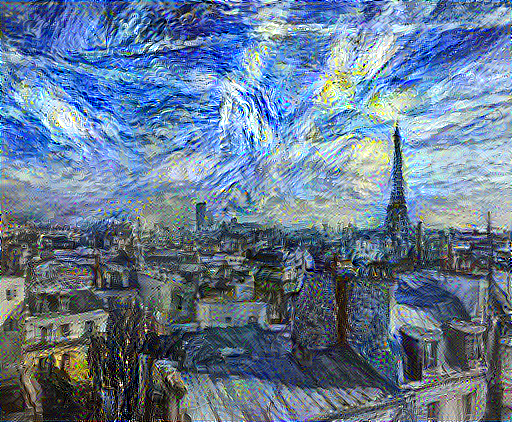

Train step: 5000


In [ ]:
import os
import tensorflow as tf

import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools
from google.colab import files


def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)

  return PIL.Image.fromarray(tensor)


# Download images and choose a style image and a content image
uploaded = files.upload()
content_image_path = list(uploaded.keys())[0]

# Tải ảnh phong cách
uploaded = files.upload()
style_image_path = list(uploaded.keys())[0]

content_path = '/content/' + content_image_path
style_path   = '/content/' + style_image_path

def load_img(path_to_img):
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  img = tf.image.resize(img, (422, 512))
  img = img[tf.newaxis, :]
  return img

def imshow(image, title=None):
  plt.imshow(image)
  if title:
    plt.title(title)

content_image = load_img(content_path)
style_image = load_img(style_path)

# plt.subplot(1, 2, 1)
# imshow(content_image[0], 'Content Image')

# plt.subplot(1, 2, 2)
# imshow(style_image[0], 'Style Image')





# Creates a vgg model that returns a list of intermediate output values
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False,
                                    weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]
  model = tf.keras.Model([vgg.input], outputs)
  return model



def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd',
                            input_tensor,
                            input_tensor)

  input_shape = tf.shape(input_tensor)
  size = input_shape[1]*input_shape[2]
  num_locations = tf.cast(size, tf.float32)

  return result/(num_locations)

class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}





# create the model:
content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers   = len(style_layers)

extractor = StyleContentModel(style_layers, content_layers)
style_targets   = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

# output
image = tf.Variable(content_image)
def clip_0_1(image):
  return tf.clip_by_value(image,
                          clip_value_min=0.0,
                          clip_value_max=1.0)

opt = tf.optimizers.Adam(learning_rate=0.02,
                         beta_1=0.99,
                         epsilon=1e-1)

style_weight   = 1e-2
content_weight = 1e4

def style_content_loss(outputs):
    style_outputs   = outputs['style']
    content_outputs = outputs['content']

    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers

    loss = style_loss + content_loss
    return loss

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

epochs = 100
steps_per_epoch = 50

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image[0]))
  print("Train step: {}".format(step))

  fname = '/content/drive/MyDrive/StyleTransfer/image/at_%d.png' % (n+1)
  mpl.image.imsave(fname, image[0].numpy())





In [ ]:
import os
import tensorflow as tf
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import functools
from google.colab import files
from IPython.display import clear_output, display

mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False


# Tải ảnh nội dung
# uploaded = files.upload()
# content_image_path = list(uploaded.keys())[0]

# Tải ảnh phong cách
uploaded = files.upload()
style_image_path = list(uploaded.keys())[0]

# Xoay ảnh phong cách
def rotate_image(image_path, degrees):
    image = PIL.Image.open(image_path)
    rotated_image = image.rotate(degrees, expand=True)
    rotated_image.save(image_path)
    return image_path

# Xoay ảnh phong cách 90 độ
style_image_path = rotate_image(style_image_path, 90)


Saving ao_dai.jpg to ao_dai.jpg


#2. Có xoay

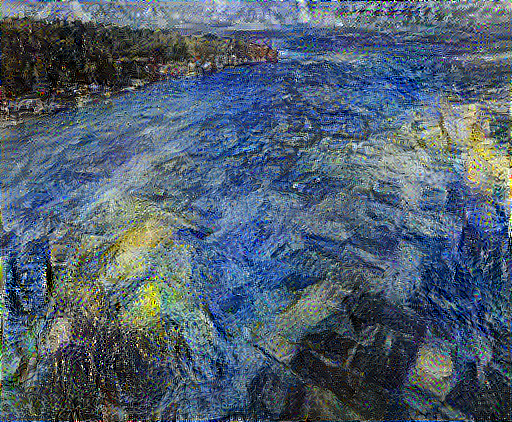

Train step: 5000


In [ ]:
import os
import tensorflow as tf

import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False
from google.colab import files


import numpy as np
import PIL.Image
import time
import functools

def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)

  return PIL.Image.fromarray(tensor)


# Download images and choose a style image and a content image
uploaded = files.upload()
content_image_path = list(uploaded.keys())[0]

# Tải ảnh phong cách
uploaded = files.upload()
style_image_path = list(uploaded.keys())[0]

# Xoay ảnh phong cách
def rotate_image(image_path, degrees):
    image = PIL.Image.open(image_path)
    rotated_image = image.rotate(degrees, expand=True)
    rotated_image.save(image_path)
    return image_path

deg = int(input("Nhập góc xoay cho ảnh phong cách (độ): "))

# Xoay ảnh phong cách 90 độ
style_image_path = rotate_image(style_image_path, deg)


content_path = '/content/' + content_image_path
style_path   = '/content/' + style_image_path

def load_img(path_to_img):
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  img = tf.image.resize(img, (422, 512))
  img = img[tf.newaxis, :]
  return img

def imshow(image, title=None):
  plt.imshow(image)
  if title:
    plt.title(title)

content_image = load_img(content_path)
style_image = load_img(style_path)

# plt.subplot(1, 2, 1)
# imshow(content_image[0], 'Content Image')

# plt.subplot(1, 2, 2)
# imshow(style_image[0], 'Style Image')





# Creates a vgg model that returns a list of intermediate output values
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False,
                                    weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]
  model = tf.keras.Model([vgg.input], outputs)
  return model



def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd',
                            input_tensor,
                            input_tensor)

  input_shape = tf.shape(input_tensor)
  size = input_shape[1]*input_shape[2]
  num_locations = tf.cast(size, tf.float32)

  return result/(num_locations)

class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}





# create the model:
content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers   = len(style_layers)

extractor = StyleContentModel(style_layers, content_layers)
style_targets   = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

# output
image = tf.Variable(content_image)
def clip_0_1(image):
  return tf.clip_by_value(image,
                          clip_value_min=0.0,
                          clip_value_max=1.0)

opt = tf.optimizers.Adam(learning_rate=0.02,
                         beta_1=0.99,
                         epsilon=1e-1)

style_weight   = 1e-2
content_weight = 1e4

def style_content_loss(outputs):
    style_outputs   = outputs['style']
    content_outputs = outputs['content']

    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers

    loss = style_loss + content_loss
    return loss

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

epochs = 100
steps_per_epoch = 50

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image[0]))
  print("Train step: {}".format(step))

  fname = '/content/drive/MyDrive/StyleTransfer/image/at_%d.png' % (n+1)
  mpl.image.imsave(fname, image[0].numpy())



